In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split

test_dataset=MNIST(root='data/',
                   train=False,
                   transform=transforms.ToTensor())

train_dataset=MNIST(root='data/',
                   train=True,
                   transform=transforms.ToTensor())


print('数据读取完毕:测试集样本数:',len(test_dataset))
print('数据读取完毕:训练集样本数:',len(train_dataset))

train_ds,val_ds=random_split(train_dataset,[50000,10000])
train_loader=DataLoader(train_ds,128,shuffle=True)
val_loader=DataLoader(val_ds,128)

for x,y in train_loader:
    one_batch_train_data=x
    one_batch_train_label=y
    break
    
print('一个标签batch:',one_batch_train_label.size())
print('一个样本batch：',one_batch_train_data.size())

数据读取完毕:测试集样本数: 10000
数据读取完毕:训练集样本数: 60000
一个标签batch: torch.Size([128])
一个样本batch： torch.Size([128, 1, 28, 28])


In [2]:
import torch.nn.functional as F
model=nn.Linear(784,10)
one_batch_train_data=one_batch_train_data.reshape(-1,784)
preds=model(one_batch_train_data)
print('model对一个batch的输出size:',preds.size())
print('一个batch的标签size:',one_batch_train_label.size())

loss=F.cross_entropy(preds,one_batch_train_label)
print(loss)

#cross_entropy 可以对（128,10）和（128）直接求loss
#预测需再前标签需在后

model对一个batch的输出size: torch.Size([128, 10])
一个batch的标签size: torch.Size([128])
tensor(2.3234, grad_fn=<NllLossBackward>)


In [7]:
one_batch_train_label.dtype

torch.int64

In [20]:
#torch.stack把list 中的torch合并在一起，总体变成一个torch

a=torch.tensor([[1.],[2.],[5.90]])
print(a)
b=[i for i in a]
print(b)
c=torch.stack(b)
print(c)



tensor([[1.0000],
        [2.0000],
        [5.9000]])
[tensor([1.]), tensor([2.]), tensor([5.9000])]
tensor([[1.0000],
        [2.0000],
        [5.9000]])
in the 10th epoch:	acc:0.348	loss:2.393


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

imputsize=28*28
numclass=10

def accuracy(out,labels):  
    _,preds=torch.max(out,dim=1)
    correct_pred=torch.sum(preds==labels)/len(labels)
    return correct_pred
    

#框架
def fit(lr,epochs,model,train_loader,val_loader,optimizer=torch.optim.SGD):
    optim=optimizer(model.parameters(),lr)
    history=[]
    #保存validation过程中的loss 和acc
    
    for epoch in range(epochs):
        
        for batch in train_loader:
            #训练过程
            
            #training_step接受一个batch，算出batch的总loss
            loss=model.training_step(batch)  
            loss.backward()
            optim.step()
            optim.zero_grad()
            
        #验证过程 不用梯度回传 但是需要输出loss和acc(此时一个batch已经结束了)
        #
        outputs=[model.validation_step(batch) for batch in val_loader]
        result=model.evaluation(outputs)
        history.append(result)
        print('in the {}th epoch:\tacc:{:.3f}\tloss:{:.3f}'.format
              (epoch+1,result['acc'],result['loss']))
    return history

class MnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(imputsize,numclass)
    
    def forward(self,xb):
        xb=xb.reshape(-1,784)
        out=self.linear(xb)
        return out
    
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        return loss
        
        
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss': loss, 'val_acc': acc}
   
    def evaluation(self,outputs):
        loss=[x['val_loss'] for x in outputs]
        acc=[x['val_acc'] for x in outputs]
        epoch_loss=torch.stack(loss).mean()
        epoch_acc=torch.stack(acc).mean()
        return {'acc':epoch_acc.item(),'loss':epoch_loss.item()}
    
    
model=MnistModel()


In [8]:
history1=fit(0.001,5,model,train_loader,val_loader)

#列表，每一项是字典

in the 1th epoch:	acc:0.590	loss:1.986
in the 2th epoch:	acc:0.719	loss:1.708
in the 3th epoch:	acc:0.758	loss:1.500
in the 4th epoch:	acc:0.781	loss:1.343
in the 5th epoch:	acc:0.796	loss:1.222


In [44]:
history2=fit(0.001,5,model,train_loader,val_loader)

in the 1th epoch:	acc:0.806	loss:1.124
in the 2th epoch:	acc:0.814	loss:1.049
in the 3th epoch:	acc:0.820	loss:0.988
in the 4th epoch:	acc:0.826	loss:0.937
in the 5th epoch:	acc:0.830	loss:0.894


In [45]:
history3=fit(0.001,5,model,train_loader,val_loader)

in the 1th epoch:	acc:0.833	loss:0.857
in the 2th epoch:	acc:0.838	loss:0.825
in the 3th epoch:	acc:0.840	loss:0.798
in the 4th epoch:	acc:0.842	loss:0.773
in the 5th epoch:	acc:0.844	loss:0.751


Text(0.5, 1.0, 'Accuracy vs. epoch')

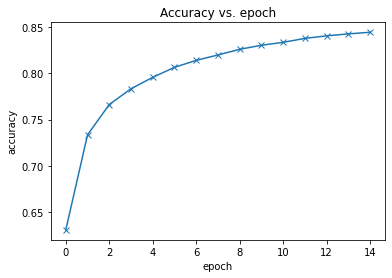

In [46]:
import matplotlib.pyplot as plt

history=history1+history2+history3
acc=[i['acc'] for i in history]
plt.plot(acc,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. epoch')

In [63]:
torch.max(pred,dim=1)[1].item()


0

8


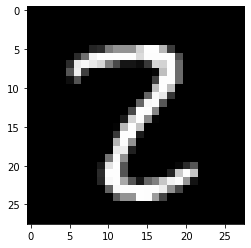

In [67]:
#testing

test_dataset=MNIST(root='data/',
                   train=False,
                   transform=transforms.ToTensor())
img,labels=test_dataset[1839]
plt.imshow(img[0],cmap='gray')
pred=model(img.reshape(-1,784))
print(torch.max(pred,dim=1)[1].item())

In [69]:
test_loader=DataLoader(test_dataset,batch_size=256)

outputs=[model.validation_step(batch) for batch in test_loader]
result=evaluation(outputs)
result

{'acc': 0.8485351800918579, 'loss': 0.7232864499092102}

In [73]:
torch.save(model.state_dict(),'mnist-logistic.pth')

In [75]:
model2=MnistModel()
outputs=[model2.validation_step(batch) for batch in test_loader]
result=evaluation(outputs)
print(result)

model2.load_state_dict(torch.load('mnist-logistic.pth'))
outputs=[model2.validation_step(batch) for batch in test_loader]
result=evaluation(outputs)
print(result)


{'acc': 0.03486328199505806, 'loss': 2.3259384632110596}
{'acc': 0.8485351800918579, 'loss': 0.7232864499092102}


In [76]:
import torch
import torch.nn as nn


model=nn.Linear(28*28,10)

    
#softmax最后要归一化，必须指定是在128维空间上归一化还是10维空间上
x=one_batch_train_data.reshape(-1,784)
y=model(x)

preds=F.softmax(y,dim=1)
max_value,max_index=torch.max(preds,dim=1)
print(max_index.size(),one_batch_train_label.size())
print(torch.sum(max_index==one_batch_train_label))
print(torch.sum(max_index==one_batch_train_label)/len(max_index))

torch.Size([128]) torch.Size([128])
tensor(14)
tensor(0.1094)


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split

test_dataset=MNIST(root='data/',
                   train=False,
                   transform=transforms.ToTensor())

train_dataset=MNIST(root='data/',
                   train=True,
                   transform=transforms.ToTensor())


print('数据读取完毕:测试集样本数:',len(test_dataset))
print('数据读取完毕:训练集样本数:',len(train_dataset))

train_ds,val_ds=random_split(train_dataset,[50000,10000])

数据读取完毕:测试集样本数: 10000
数据读取完毕:训练集样本数: 60000


In [4]:
from torch.utils.data import DataLoader
from 
train_loader=DataLoader(train_ds,20)

In [6]:
for i in train_loader:
    x=i
    break

In [8]:
x[0].shape

torch.Size([20, 1, 28, 28])